In [1]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("Aircraft_Landing_Facilities.csv")

# Convert numeric columns
numeric_cols = ['ELEV', 'CBD_DIST', 'Passengers', 'Departures', 'Arrivals', 'ITIN_OPS', 'LOCAL_OPS', 'MIL_OPS', 
    'Passengers', 'S_ENG_GA', 'M_ENG_GA', 'JET_EN_GA', 'HELICOPTER','COMM_SERV']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing coordinates
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

/var/folders/j1/d8pjh6396nz02h66dnsx5hfr0000gn/T/ipykernel_57691/2883527250.py:10: DtypeWarning: Columns (11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Aircraft_Landing_Facilities.csv")


In [2]:
df

,index,X,Y,FID,SITE_NO,LAN_FA_TY,LOCID,EFF_DATE,FAA_REGION,FAA_DISTRI,...,ULTRALIGHT,COMM_SERV,AIR_TAXI,LOCAL_OPS,ITIN_OPS,MIL_OPS,Arrivals,Departures,Enplanemen,Passengers
0,0,-112.194361,35.305500,1002,00831.*A,AIRPORT,CMR,04/03/2014,AWP,LAX,...,,NaN,000100,1500.0,4500.0,NaN,0,0,0,0
1,1,-91.562667,36.264889,1003,00867.*A,AIRPORT,CVK,04/03/2014,ASW,AOK,...,,NaN,,1100.0,1100.0,100.0,0,0,0,0
2,2,-111.935719,35.238344,1004,00831.1*A,AIRPORT,AZ77,04/03/2014,AWP,LAX,...,,NaN,,NaN,NaN,NaN,0,0,0,0
3,3,-91.358462,35.288697,1005,00871.1*H,HELIPORT,AR76,04/03/2014,ASW,AOK,...,,NaN,,NaN,NaN,NaN,0,0,0,0
4,4,-109.067389,35.652056,1006,00833.1*A,AIRPORT,RQE,04/03/2014,AWP,LAX,...,002,NaN,,1500.0,3500.0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16414,16414,-84.128056,33.820833,4003,04024.2*H,HELIPORT,3GE2,04/03/2014,ASO,ATL,...,,NaN,,NaN,NaN,NaN,0,0,0,0
16415,16415,-114.334167,42.587778,4004,04187.4*A,AIRPORT,1ID7,04/03/2014,ANM,SEA,...,,NaN,,NaN,NaN,NaN,0,0,0,0
16416,16416,-83.649211,32.692850,4005,03902.*A,AIRPORT,MCN,04/03/2014,ASO,ATL,...,,313.0,001826,1610.0,10395.0,3896.0,0,0,1884,4646
16417,16417,-115.439850,45.822686,4006,04188.1*A,AIRPORT,S90,04/03/2014,ANM,SEA,...,,NaN,000200,NaN,1200.0,NaN,0,0,0,0


In [3]:
# --- Interactive Map ---
# Creates a base map centered on the approximate center of the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=5)
# Creates a marker cluster group to handle many markers efficiently
marker_cluster = MarkerCluster().add_to(m)

for i, row in df.iterrows():
    # Creates HTML-formatted popup text for each marker
    popup_text = f"""
    <b>{row['FULLNAME']}</b><br>
    City: {row['CITY_NAME']}<br>
    Type: {row['LAN_FA_TY']}<br>
    Owner: {row['OWNER_TYPE']}<br>
    Elevation: {row['ELEV']}<br>
    Latitude:{row['LATITUDE']}<br>
    Longitude: {row['LONGITUDE']} m
    """
    # Adds a marker for each facility
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=popup_text,# Information shown when clicked
        # Blue icons for airports, green for other facilities
        icon=folium.Icon(color='blue' if row['LAN_FA_TY'] == 'AIRPORT' else 'green')
    ).add_to(marker_cluster)

m.save("aircraft_facilities_map.html")

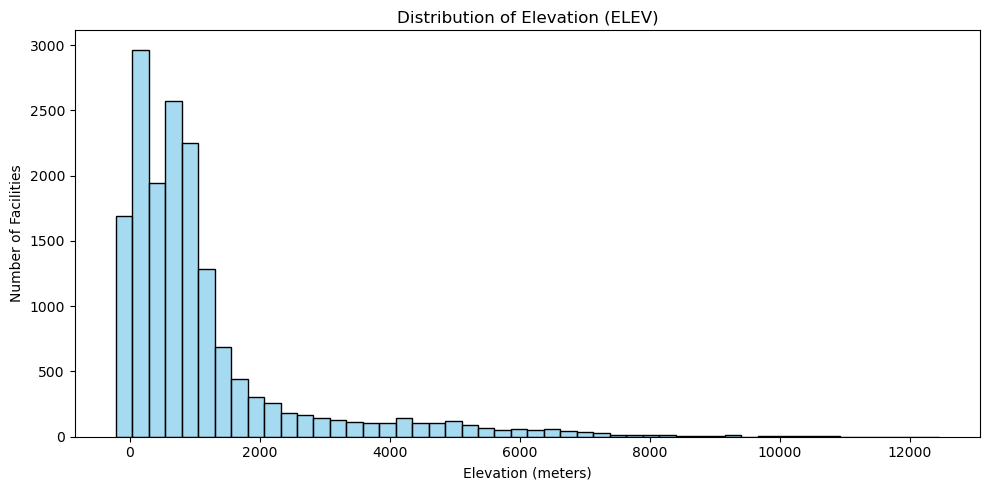

In [4]:
# --- Elevation Distribution ---
plt.figure(figsize=(10, 5))
sns.histplot(df['ELEV'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of Elevation (ELEV)')
plt.xlabel('Elevation (meters)')
plt.ylabel('Number of Facilities')
plt.tight_layout()
# plt.savefig("elevation_distribution.png")
# plt.close()

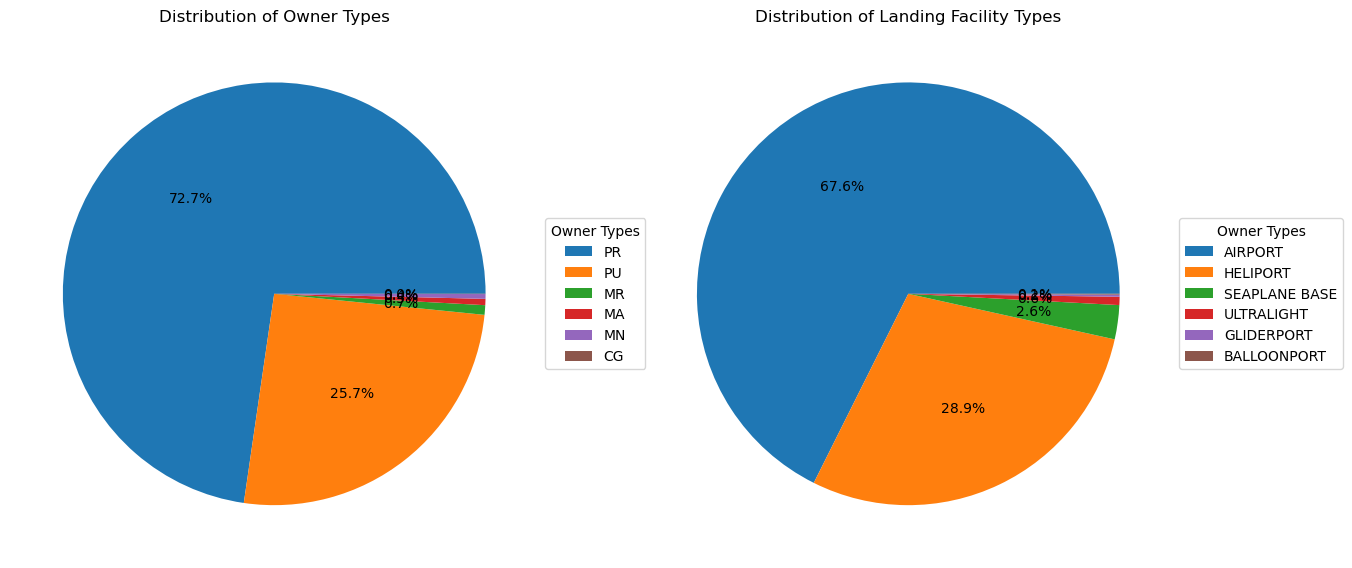

In [5]:
# --- Owner Type Distribution ---
plt.figure(figsize=(15, 7))

# First pie chart - Owner Types
plt.subplot(1, 2, 1)
owner_counts = df['OWNER_TYPE'].value_counts()
plt.title('Distribution of Owner Types')
# Pie without labels
wedges, texts, autotexts = plt.pie(owner_counts.values, autopct='%1.1f%%')
# Add legend
plt.legend(wedges, owner_counts.index, title="Owner Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# plt.pie(owner_counts.values, labels=owner_counts.index, autopct='%1.1f%%')
# plt.title('Distribution of Owner Types')
# plt.pie(owner_counts.values, labels=owner_counts.index, autopct='%1.1f%%',
#         labeldistance=1.1, pctdistance=0.8)

# Second pie chart - Facility Use
plt.subplot(1, 2, 2)
fac_use_counts = df['LAN_FA_TY'].value_counts()
# plt.pie(fac_use_counts.values, labels=fac_use_counts.index, autopct='%1.1f%%')
wedges, texts, autotexts = plt.pie(fac_use_counts.values, autopct='%1.1f%%')
plt.title('Distribution of Landing Facility Types')
# Add legend
plt.legend(wedges, fac_use_counts.index, title="Owner Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# plt.title('Distribution of Landing Facility Types')

# plt.tight_layout()


Regarding the owner type codes, they typically represent:

- PR: Private
- PU: Public
- MA: Military/Army
- MN: Military/Navy
- MR: Military/Reserve
- AF: Air Force
- CG: Coast Guard
- PB: Public/Private

These codes are standard FAA (Federal Aviation Administration) ownership designators. The data shows that:

Most facilities are privately owned (PR)

Public facilities (PU) form the second largest group

Military facilities (MA, MN, MR, AF) make up a smaller portion but are significant for national defense

There's a mix of civilian and military ownership, which is typical for aviation infrastructure

/var/folders/j1/d8pjh6396nz02h66dnsx5hfr0000gn/T/ipykernel_57691/3017466146.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Passengers', y='FULLNAME', data=top_passenger_facilities, palette='Blues_d')


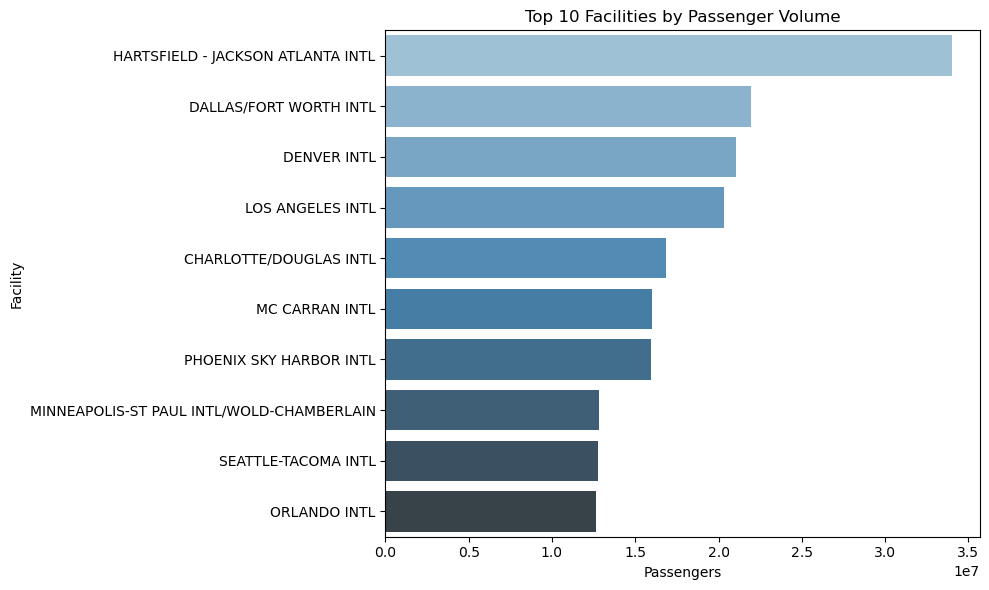

In [6]:
# --- Top 10 Passenger Facilities ---
top_passenger_facilities = df.nlargest(10, 'Passengers')[['FULLNAME', 'Passengers']].dropna()
plt.figure(figsize=(10, 6))
sns.barplot(x='Passengers', y='FULLNAME', data=top_passenger_facilities, palette='Blues_d')
plt.title('Top 10 Facilities by Passenger Volume')
plt.xlabel('Passengers')
plt.ylabel('Facility')
plt.tight_layout()
# plt.savefig("top_passenger_facilities.png")
# plt.close()

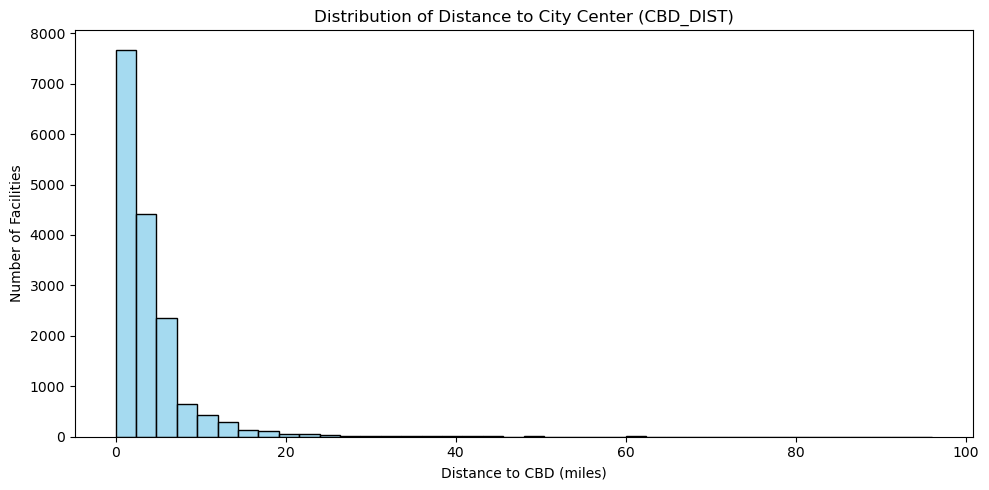

In [7]:
# --- CBD Distance Histogram ---
plt.figure(figsize=(10, 5))
sns.histplot(df['CBD_DIST'].dropna(), bins=40, color='skyblue')
plt.title('Distribution of Distance to City Center (CBD_DIST)')
plt.xlabel('Distance to CBD (miles)')
plt.ylabel('Number of Facilities')
plt.tight_layout()
# plt.savefig("cbd_distance_distribution.png")
# plt.close()

In [8]:
#  --- Operational Efficiency Analysis ---
# Calculate operational efficiency metrics
df['Total_Operations'] = df['ITIN_OPS'] + df['LOCAL_OPS'] + df['MIL_OPS']
df['Passenger_Throughput'] = df['Passengers'] / df['Total_Operations']

# Create a heatmap of operational efficiency by state
efficiency_by_state = df.groupby('STATE_NAME')['Passenger_Throughput'].mean()

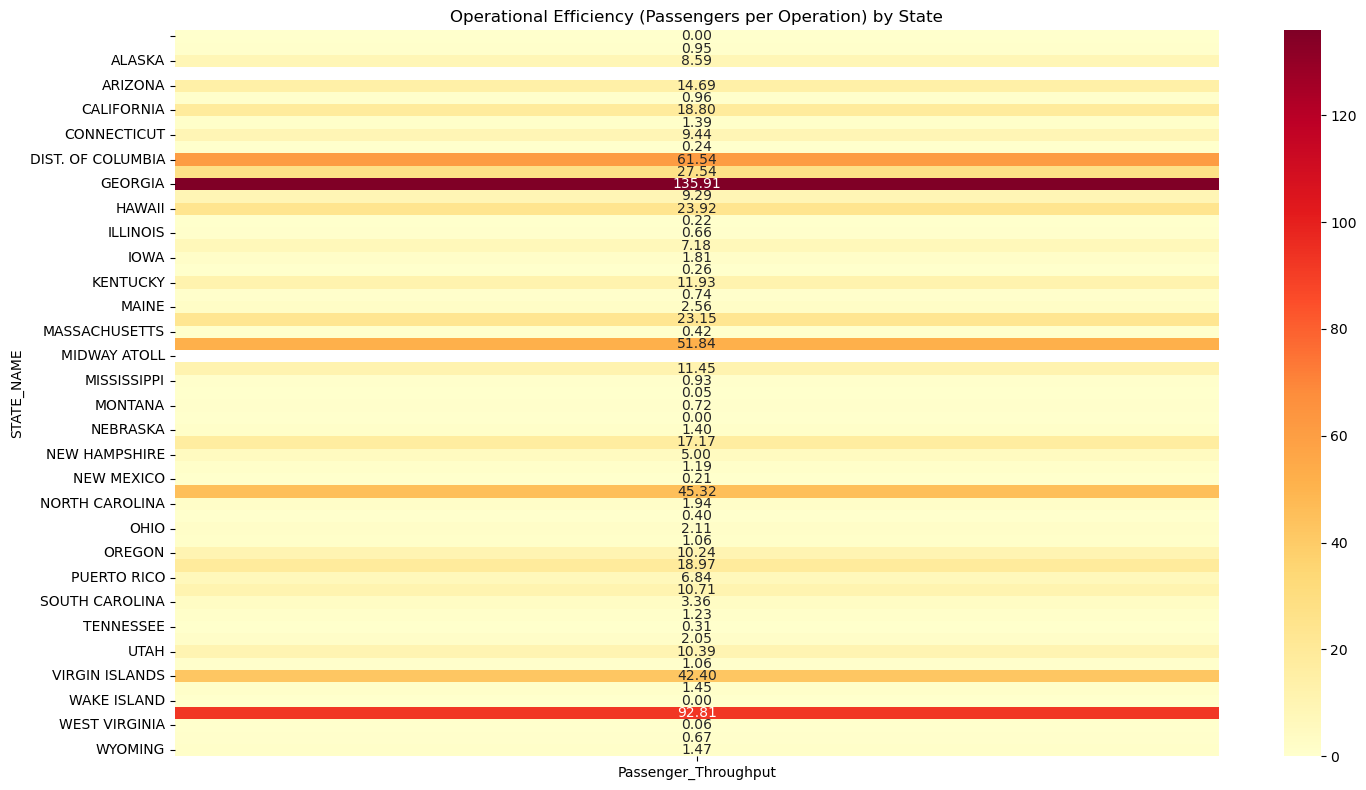

In [9]:
# 1. Heatmap of operational efficiency by state
plt.figure(figsize=(15, 8))
efficiency_by_state = df.groupby('STATE_NAME')['Passenger_Throughput'].mean()
efficiency_matrix = efficiency_by_state.to_frame()
sns.heatmap(efficiency_matrix, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Operational Efficiency (Passengers per Operation) by State')
plt.tight_layout()
plt.show()

In [10]:
# Import libraries
import plotly.express as px
# import matplotlib.pyplot as plt
# import geopandas as gpd
# import pandas as pd
# import requests

# Prepare efficiency data
efficiency_by_state = df.groupby('FAA_ST')['Passenger_Throughput'].mean().reset_index()

# Create choropleth map using state abbreviations
fig = px.choropleth(
    efficiency_by_state,
    locations='FAA_ST',  # Use the two-letter state code
    locationmode='USA-states',  # This mode works with state abbreviations
    color='Passenger_Throughput',
    scope="usa",
    color_continuous_scale="YlOrRd",
    labels={'Passenger_Throughput': 'Passengers per Operation', 'FAA_ST': 'State'}
)

# Update layout for better appearance
fig.update_layout(
    title_text='Aviation Operational Efficiency by State',
    geo=dict(
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    ),
    coloraxis_colorbar=dict(
        title='Passengers per Operation'
    )
)

fig.show()

In [11]:
import pandas as pd
# --- Economic Impact Analysis ---  
# Create a composite score for facility importance:
importance_score = (
    df['Passengers'] * 0.3 + 
    df['Total_Operations'] * 0.2 +
    df['COMM_SERV'] * 0.2 + #commercial services
    (df['CNTL_TWR'] == 'Y').astype(int) * 0.1 + #control tower
    (df['CUST_LNDG'] == 'Y').astype(int) * 0.1 #customs landing services
)

df['Importance_Score'] = importance_score.fillna(0)
# Map this to show economic hubs in aviation
# df = dropna(df, subset=['Importance_Score'])

In [12]:
# Map of economic hubs
import plotly.express as px

fig2 = px.scatter_geo(
    df,
    lat='LATITUDE',
    lon='LONGITUDE',
    size='Importance_Score',
    color='Importance_Score',
    hover_name='FULLNAME',
    scope='usa',
    title='Economic Hubs in US Aviation Infrastructure',
    color_continuous_scale='Viridis',
    size_max=20
)

fig2.update_layout(
    geo=dict(
        scope='usa',
        projection_scale=1,
        center=dict(lat=39.8283, lon=-98.5795)
    )
)

fig2.show()